In [1]:
import numpy as np
import numpy.ma as ma
from scipy.stats import norm, linregress
import matplotlib.pyplot as plt


def simulate_ar1(phi, sigma_tilde, n, zero_ends=False):
    """
    Simulates an AR(1) process.

    Parameters:
        phi (float): AR(1) coefficient.
        sigma_tilde (float): Standard deviation of noise.
        n (int): Length of the time series.
        zero_ends (bool): If True, modifies the process to zero the ends.

    Returns:
        numpy.ndarray: Simulated time series.
    """
    # Initialize the time series array
    y = np.zeros(n)
    
    # Generate noise from a standard normal distribution
    noise = norm.rvs(size=n)

    if zero_ends:
        n = n - 1  # Adjust the length
    else:
        # Set the first value of y
        y[0] = norm.rvs(scale=sigma_tilde / np.sqrt(1 - phi**2))

    # Simulate the AR(1) process
    for i in range(1, n):
        y[i] = phi * y[i - 1] + sigma_tilde * noise[i - 1]

    # Add gaps (missing values) if needed
    n_gaps = 50  # Modify as necessary
    n_outl = 20
    if n_gaps+n_outl > 0:
        points = np.random.choice(range(n), size=n_gaps+n_outl, replace=False)
        y[points[:n_gaps]] = np.nan
        y[points[n_gaps:n_gaps+n_outl]] = norm.rvs(scale=5*sigma_tilde / np.sqrt(1 - phi**2), size=n_outl)


    return y


In [2]:
def calc_ar1(x):
    #return np.corrcoef(x[:-1], x[1:])[0,1]
    return ma.corrcoef(ma.masked_invalid(x[:-1]), ma.masked_invalid(x[1:]))[0,1]

def compute_lam(x, dt=1):
    dx = (x[1:] - x[:-1]) / dt
    x0 = x[:-1]
    mask = ~np.isnan(x0) & ~np.isnan(dx)
    return linregress(x0[mask], dx[mask])[0]

def compute_sigma(x, dt=1):
    dx = (x[1:] - x[:-1]) / dt
    lamb = compute_lam(x, dt)
    diff = dx - lamb * x[:-1]
    return np.nanstd(diff) * np.sqrt(dt)

def estimate_lambda_ac1(X):
    lg = np.log(calc_ar1(X))
    if np.isnan(lg):
        lg = np.nan
    return lg

def estimate_lambda_var(X):
    sigma = compute_sigma(X)
    var = np.nanvar(X)
    rr_var = 0.5 * np.log(1-sigma**2 / var)
    if np.isnan(rr_var):
        rr_var = np.nan
    return rr_var

/var/folders/tz/fzy4bpxd7j54282vbs0hj3cm0000gn/T/ipykernel_64684/674474282.py:18: RuntimeWarning: invalid value encountered in log
  lg = np.log(calc_ar1(X))
/var/folders/tz/fzy4bpxd7j54282vbs0hj3cm0000gn/T/ipykernel_64684/674474282.py:26: RuntimeWarning: invalid value encountered in log
  rr_var = 0.5 * np.log(1-sigma**2 / var)


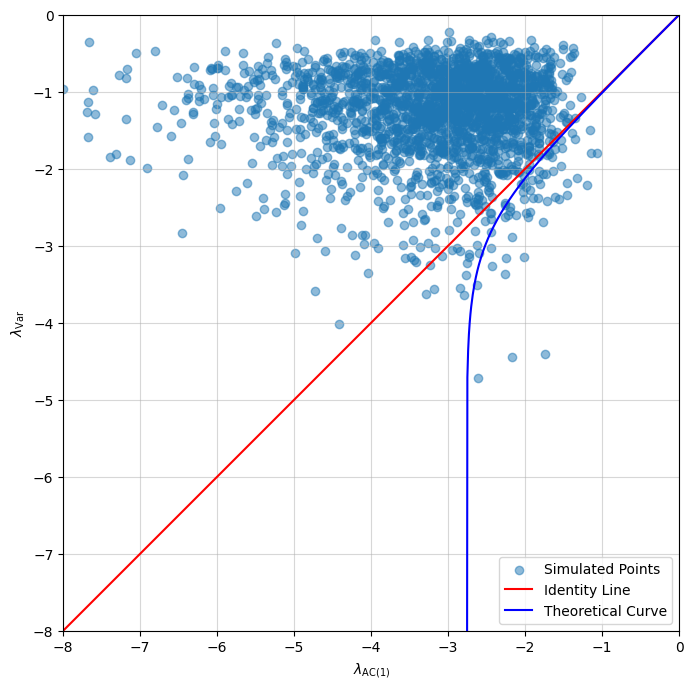

In [3]:
# Define parameters
_lambda = -4
phi = np.exp(_lambda)
sigma_tilde = 1
n = 250
m = 10000
zero_ends = False

# Simulate m time series using the AR(1) function
ts = [simulate_ar1(phi, sigma_tilde, n, zero_ends=zero_ends) for _ in range(m)]



# Compute (lambda_AC1, lambda_Var) points
points = [
    (estimate_lambda_ac1(X),
     estimate_lambda_var(X))
    for X in ts
]

# Convert points to numpy array for easier manipulation
points = np.array(points)

# Define axis limits
min_ax = _lambda * 2
max_ax = 0

# Define the line for plotting
line_points = np.arange(0.5 * np.log(1 / n) + 1e-10, max_ax, 0.01)
line_curve = [0.5 * np.log(1 - n / (n - 1) * (1 - np.exp(2 * x))) for x in line_points]

# Scatter plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(points[:, 0], points[:, 1], alpha=0.5, label="Simulated Points")
ax.plot([min_ax, max_ax], [min_ax, max_ax], color="red", label="Identity Line")
ax.plot(line_points, line_curve, color="blue", label="Theoretical Curve")

# Set aspect ratio and limits
ax.set_aspect('equal', 'box')
ax.set_xlim(min_ax, max_ax)
ax.set_ylim(min_ax, max_ax)
ax.set_xlabel(r"$\lambda_{\mathrm{AC(1)}}$")
ax.set_ylabel(r"$\lambda_{\mathrm{Var}}$")
ax.legend()
ax.grid(alpha=0.5)

plt.show()


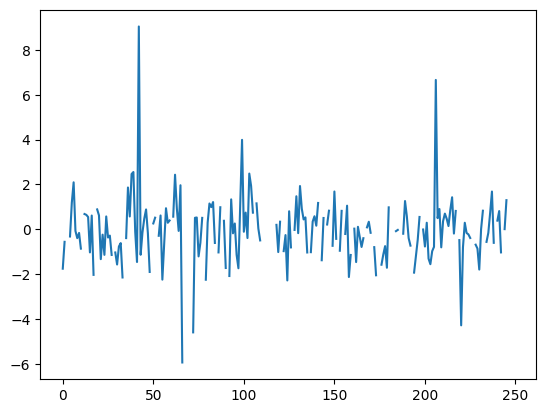

In [4]:
plt.plot(ts[0])